In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
from functools import partial

import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
np.random.seed(1)

/home/dl/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

In [3]:
class data_augment():
    def __init__(self, dataset, dataset_labels):
        
        self.dataset = dataset;
        self.dataset_labels = dataset_labels;
        
        self.augmented_image = []
        self.augmented_image_labels = []
        
        self.status = "None";
        
        self.image = tf.placeholder(tf.uint8, shape=(None, None, 3))
        self.tensors = [];
        
        return None;
    
    def add_tensor(self, tensor, feed_dict):
        self.tensors.append([tensor, feed_dict]);
        return self;
    
    def append(self, num, image):
        image = scipy.misc.imresize(image, size=(64,64))
        
        self.augmented_image.append(image)
        self.augmented_image_labels.append(self.dataset_labels[num]);
        return self;
    
    def run(self):
        
        with tf.Session() as sess:
            for image_index in range(0, self.dataset.shape[0]):
                self.append(image_index, self.dataset[image_index]);
                for tensor_index in range(0, len(self.tensors)):
                    fd = self.tensors[tensor_index][1];
                    fd[self.image] = self.dataset[image_index];
                    self.append(image_index, sess.run( self.tensors[tensor_index][0], feed_dict = fd ))
        
        return [np.array(self.augmented_image), np.array(self.augmented_image_labels), self.tensors];

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


<Figure size 216x216 with 0 Axes>

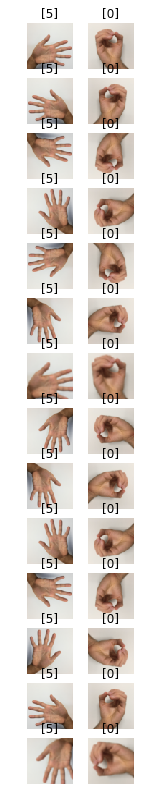

In [4]:
# Start 1 data augment
da = data_augment(X_train_orig, Y_train_orig.T);

da.add_tensor(tf.image.transpose_image(da.image), {da.image: da.image} );

[augmented_image, augmented_image_labels, tensors] = da.run()

horizontal_size = len(tensors) + 1
# End 1 data augment

# Start 2 data augment
da = data_augment(augmented_image, augmented_image_labels);

da.add_tensor(tf.image.flip_left_right(da.image), {da.image: da.image} );
da.add_tensor(tf.image.flip_up_down(da.image), {da.image: da.image} );
da.add_tensor(tf.image.rot90(da.image, k = 1), {da.image: da.image} );
da.add_tensor(tf.image.rot90(da.image, k = 2), {da.image: da.image} );
da.add_tensor(tf.image.rot90(da.image, k = 3), {da.image: da.image} );
da.add_tensor(tf.image.central_crop(da.image, 0.8), {da.image: da.image} );

[augmented_image, augmented_image_labels, tensors] = da.run()

horizontal_size = len(tensors) * horizontal_size + horizontal_size
# End 2 data augment

# Start 3 data augment
# da = data_augment(augmented_image, augmented_image_labels);

# da.add_tensor(tf.image.adjust_brightness(da.image, 0.3), {da.image: da.image} );
# da.add_tensor(tf.image.adjust_brightness(da.image, 0.5), {da.image: da.image} );
# da.add_tensor(tf.image.adjust_contrast(da.image, 0.7), {da.image: da.image} );
# da.add_tensor(tf.image.adjust_contrast(da.image, 0.5), {da.image: da.image} );
# da.add_tensor(tf.image.adjust_contrast(da.image, 0.3), {da.image: da.image} );

# [augmented_image, augmented_image_labels, tensors] = da.run()

# horizontal_size = len(tensors) * horizontal_size + horizontal_size
# End 3 data augment

augmented_image = np.array(augmented_image);

augmented_image_size = horizontal_size * 2 # augmented_image.shape[0]

vertical_size = (augmented_image_size // horizontal_size) + ( (augmented_image_size % horizontal_size) > 0 );

plt.figure(figsize=(3,3))
f, axarr = plt.subplots( horizontal_size, vertical_size, figsize=(vertical_size, horizontal_size) )
j = 1;
k = 0;
for i in range(0, augmented_image_size):
    
    if k > 0 and k % horizontal_size == 0:
        j += 1;
        k = 0;
    k += 1;
    
    img = axarr[k - 1, j - 1].imshow(augmented_image[i], interpolation='nearest')
    img.set_cmap('hot')
    axarr[k-1, j-1].axis('off')
    axarr[k-1, j-1].set_title(augmented_image_labels[i])


In [5]:
with h5py.File('datasets/data_augmented_train.h5', 'w') as hf:
    hf.create_dataset( "train_set_x",  data=augmented_image )
    hf.create_dataset( "train_set_y",  data=augmented_image_labels.reshape((augmented_image_labels.shape[0])) )
    hf.create_dataset( "classes",  data=classes )